In [2]:
#for data manipulation
import pandas as pd
import numpy as np
import re
import string

#for methods and stopwords text processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# package which is used for data visualization.
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning models 
from sklearn.metrics import accuracy_score,precision_score, f1_score,confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

## download the stopwords corpus and create a set of English stopwords words such as ("the," "and," "a,") which not provide much meaning to the text

In [3]:
import nltk
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ELZAHBIA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import pandas as pd
def load_DataSet(path):
    DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
    df = pd.read_csv(path, encoding='latin-1',names=DATASET_COLUMNS)
    return df
data=load_DataSet("C:/Users/ELZAHBIA/OneDrive - King Salman International University/Desktop/train_test.csv")
data = data[['sentiment','text']]
data['sentiment'] = data['sentiment'].replace(4,1)
#print(data)

## count the number of occurrences of each unique value in a column and creates a bar plot of the distribution of data based on the sentiment label

0    800000
1    800000
Name: sentiment, dtype: int64


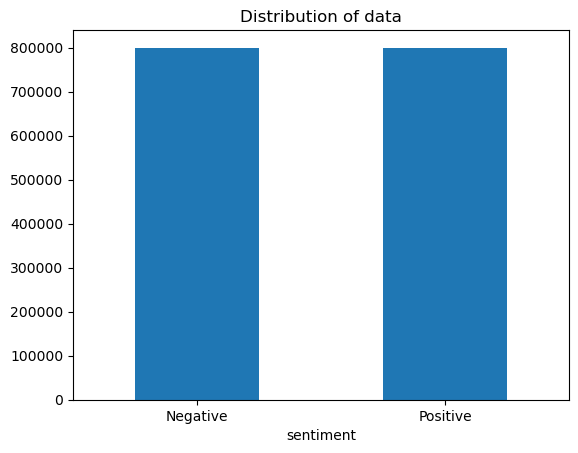

In [5]:
print(data['sentiment'].value_counts())
ax = data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
plt.show()

# pre-processing the data
## 1-casing => to lower case
## 2-remove noise  =>remove url, punctuation , user @ references and '#' from tweet
## 3-tokenization  => tokenize a tweet into individual words 
## 4-stopword Removal => remove stopwords 
## 5-text normalization (Stemming and lemmatization)  


In [6]:
def preprocess_tweet(tweet):
    #casing
    tweet=tweet.lower()
    # remove url from tweet
    tweet=re.sub(r"http\S+|www\S+|https\S+", "",tweet,flags=re.MULTILINE)
    #remove punctuation
    tweet=tweet.translate(str.maketrans('', '', string.punctuation))
    #remove user @ references and '#' from tweet
    tweet=re.sub(r'\@\w+|\#',"",tweet)
    #remove stopwords
    tweet_tokens=word_tokenize(tweet)
    filtered_words=[word for word in tweet_tokens if word not in stop_words]
    
    #stemming => reducing a word to its root or base form by removing any prefixes or suffixes
    ps=PorterStemmer()
    stemmed_words=[ps.stem(w) for w in filtered_words]
    #lemmatization => transforming words to their base or dictionary form
    lemmatizer=WordNetLemmatizer()
    lemma_words=[lemmatizer.lemmatize(w,pos='a')for w in stemmed_words]
    
    return " ".join(lemma_words)
data['text'] = data['text'].apply(lambda x: preprocess_tweet(x))
print(data.head())

   sentiment                                               text
0          0  switchfoot that bummer shoulda got david carr ...
1          0  upset cant updat facebook text might cri resul...
2          0  kenichan dive mani time ball manag save 50 res...
3          0                    whole bodi feel itchi like fire
4          0              nationwideclass behav im mad cant see


In [7]:
def evaluate(y_test, y_predict, model):
    print("\nMODEL: " + str(model))
    print('Accuracy: ', metrics.accuracy_score(y_test, y_predict))
    print("Precision: ", metrics.precision_score(y_test, y_predict))
    print("Recall: ", metrics.recall_score(y_test, y_predict))
    print("F1 Score: ", metrics.f1_score(y_test, y_predict))
    
    # Generate confusion matrix and plot it
    cf_matrix = confusion_matrix(y_test, y_predict)
        
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [8]:
# split dataset and convert the text data into a vectorized representation
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['sentiment'], test_size=0.2, random_state=42)

# Define function to get feature vectors from text data using TF-IDF vectorization
def get_feature_vector(X_train, ngram_range=(1,1)):
    vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=ngram_range)
    X_train_vec = vectorizer.fit_transform(X_train)
    return X_train_vec, vectorizer


MODEL: Naive Bayes with n-gram (1,10)
Accuracy:  0.78725625
Precision:  0.8054622848531316
Recall:  0.7592239542447011
F1 Score:  0.781659920846189


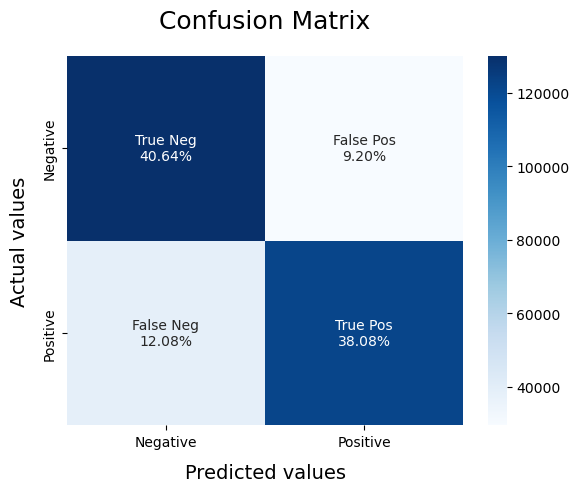

In [9]:
# Get feature vectors with n-gram (1,10) from training data for Naive Bayes
X_train_vec_nb, vectorizer_nb = get_feature_vector(X_train, ngram_range=(1,10))
# Get feature vectors with n-gram (1,10) from test data using the same vectorizer used for training for Naive Bayes
X_test_vec_nb = vectorizer_nb.transform(X_test)

# Initialize Naive Bayes classifier and fit to training data
NB = MultinomialNB()
NB.fit(X_train_vec_nb, y_train)
# Predict class labels for test data using Naive Bayes classifier
y_pred_nb = NB.predict(X_test_vec_nb)
# Evaluate performance of Naive Bayes classifier
evaluate(y_test, y_pred_nb, 'Naive Bayes with n-gram (1,10)')


MODEL: Logistic Regression without n-gram
Accuracy:  0.782878125
Precision:  0.7766727658462156
Recall:  0.7960138561798313
F1 Score:  0.7862243814786668


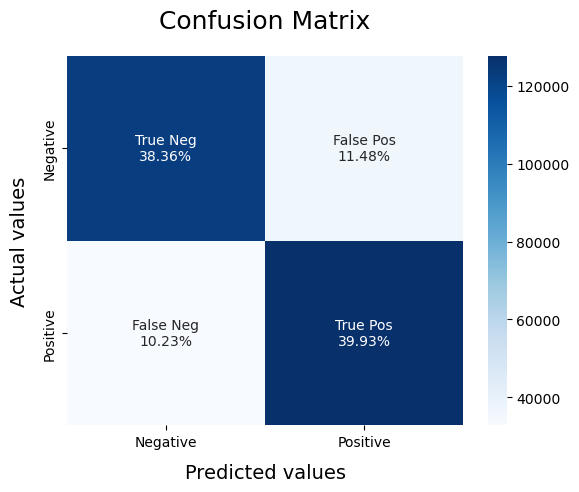

In [10]:
# Get feature vectors without n-gram from training data for logistic regression
X_train_vec_lr, vectorizer_lr = get_feature_vector(X_train)
# Get feature vectors without n-gram from test data using the same vectorizer used for training for logistic regression
X_test_vec_lr = vectorizer_lr.transform(X_test)
# Initialize logistic regression classifier and fit to training data
LR = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LR.fit(X_train_vec_lr, y_train)
# Predict class labels for test data using logistic regression classifier
y_pred_lr = LR.predict(X_test_vec_lr)
# Evaluate performance of logistic regression classifier
evaluate(y_test, y_pred_lr, 'Logistic Regression without n-gram')

In [26]:
# map integer labels (0 and 1) to their corresponding sentiment labels ("NEGATIVE" and "POSITIVE")
decode_map = {0: "NEGATIVE", 1: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [45]:
def predict(text, model):
    # Vectorize the input text based on the model used
    if model == NB:
        text_vec = vectorizer_nb.transform([text])
    elif model == LR:
        text_vec = vectorizer_lr.transform([text])
    else:
        raise ValueError("Invalid model")

    # Make the prediction using the trained model
    probabilities = model.predict_proba(text_vec)[0]

    # Decode the sentiment labels
    labels = [decode_sentiment(i) for i in range(len(probabilities))]

    # Create a dictionary mapping labels to probabilities
    scores = dict(zip(labels, probabilities))

    return scores

scores = predict("i hate you", LR)
highest_score_label = max(scores, key=scores.get)
highest_score = scores[highest_score_label]

# Print the predicted sentiment probabilities for each sentiment label
for label, score in scores.items():
    print("Sentiment Label:", label)
    print("Score:", score)
    print()

# Print the label (NEGATIVE,POSITIVE) with the highest score
print("Label with the highest score:", highest_score_label)

Sentiment Label: NEGATIVE
Score: 0.8966410176906355

Sentiment Label: POSITIVE
Score: 0.10335898230936447

Label with the highest score: NEGATIVE


# intialize variables for CNN model 

In [46]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024
# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

# training of a Word2Vec model 

In [47]:
documents = [_text.split() for _text in data['text']] 

import gensim

w2v_model = gensim.models.Word2Vec(
    vector_size=W2V_SIZE,
    window=W2V_WINDOW,
    min_count=W2V_MIN_COUNT,
    workers=8
)

w2v_model.build_vocab(documents)


words = w2v_model.wv.index_to_key
vocab_size = len(words)
print("Vocab size:", vocab_size)      # print total number of unique words in the vocabulary

w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

# find similar words
similar_words = w2v_model.wv.most_similar("love")
print(similar_words)

Vocab size: 37452
[('amaz', 0.5555484294891357), ('luv', 0.512555718421936), ('lt3', 0.4887363910675049), ('awesom', 0.4566468298435211), ('ador', 0.45373138785362244), ('looov', 0.4461888074874878), ('â\x99¥', 0.4349956810474396), ('miss', 0.43210896849632263), ('loov', 0.39677688479423523), ('great', 0.3964860439300537)]


In [48]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()        # to convert text data into a numerical representation 
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)   # Prints the total number of words in the vocabulary.

from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)   #  converts each text in X_train into a sequence of integers based on the word indices obtained from the tokenizer
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)


Total words 618925


In [49]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()     # encode categorical labels as integers
encoder.fit(y_train.tolist())

y_train = encoder.transform(y_train.tolist())
y_test = encoder.transform(y_test.tolist())

# reshape method. This is done to ensure that the label arrays have the correct shape for further processing or model training.
# -1 in the reshape indicates that the dimension is inferred based on the length of the array
# 1 indicates that the array has only one column.
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [50]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    # ensures that the word has a pre-trained word embedding available in the Word2Vec model.
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
# print shape of the embedding matrix represents the number of unique words in the tokenizer's word index (rows) and the dimensionality of the word embeddings (columns).
print(embedding_matrix.shape)   

(618925, 300)


In [51]:
from tensorflow.keras.layers import Embedding
# vocab_size : The total number of unique words in the vocabulary
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)


# # Build CNN Model
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import Dense, Dropout, Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


# binary_crossentropy :commonly used for binary classification tasks.It is suitable when the model is trained to predict a single binary output
model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])

# adjust learning rates and stop training early based on specific conditions.
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
            EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]
history = model.fit(x_train, y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.1,verbose=1,callbacks=callbacks)

# evaluate the model
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("ACCURACY:",score[1])
print("LOSS:",score[0])

Epoch 1/8
1125/1125 [==============================] - 6293s 6s/step - loss: 0.5119 - accuracy: 0.7456 - val_loss: 0.4662 - val_accuracy: 0.7804 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - 6624s 6s/step - loss: 0.4784 - accuracy: 0.7689 - val_loss: 0.4557 - val_accuracy: 0.7877 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - 6429s 6s/step - loss: 0.4703 - accuracy: 0.7741 - val_loss: 0.4499 - val_accuracy: 0.7899 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - 6613s 6s/step - loss: 0.4659 - accuracy: 0.7765 - val_loss: 0.4469 - val_accuracy: 0.7932 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - 5969s 5s/step - loss: 0.4633 - accuracy: 0.7779 - val_loss: 0.4440 - val_accuracy: 0.7942 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - 6321s 6s/step - loss: 0.4609 - accuracy: 0.7797 - val_loss: 0.4432 - val_accuracy: 0.7940 - lr: 0.0010
Epoch 7/8
1125/1125 [==============================]

# predict the sentiment of the text 

In [59]:
import time

POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE
    
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  
predict("i don't know what i'm doing")


1/1 [==============================] - 0s 172ms/step


{'label': 'NEUTRAL',
 'score': 0.5908474326133728,
 'elapsed_time': 0.32213687896728516}

# save models used 

In [65]:
import pickle

with open('NB_pkl', 'wb') as files:
    pickle.dump(NB, files)

with open('LR_pkl', 'wb') as files:
    pickle.dump(LR, files)

    
model.save('KERAS_MODEL.h5')
w2v_model.save('WORD2VEC_MODEL.w2v')
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

